In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import functools
import plotly.express as px
spark = SparkSession.builder.appName("Chicago_crime_analysis").getOrCreate()

In [2]:
from pyspark.sql.types import  (StructType, 
                                StructField, 
                                DateType, 
                                BooleanType,
                                DoubleType,
                                IntegerType,
                                StringType,
                               TimestampType)
crimes_schema = StructType([
                            StructField(" ", StringType(), True),
                            StructField("ID", StringType(), True),
                            StructField("CaseNumber", StringType(), True),
                            StructField("Date", StringType(), True ),
                            StructField("Block", StringType(), True),
                            StructField("IUCR", StringType(), True),
                            StructField("PrimaryType", StringType(), True  ),
                            StructField("Description", StringType(), True ),
                            StructField("LocationDescription", StringType(), True ),
                            StructField("Arrest", BooleanType(), True),
                            StructField("Domestic", BooleanType(), True),
                            StructField("Beat", StringType(), True),
                            StructField("District", StringType(), True),
                            StructField("Ward", StringType(), True),
                            StructField("CommunityArea", StringType(), True),
                            StructField("FBICode", StringType(), True ),
                            StructField("XCoordinate", DoubleType(), True),
                            StructField("YCoordinate", DoubleType(), True ),
                            StructField("Year", IntegerType(), True),
                            StructField("UpdatedOn", DateType(), True ),
                            StructField("Latitude", DoubleType(), True),
                            StructField("Longitude", DoubleType(), True),
                            StructField("Location", StringType(), True )
                            ])

In [3]:
def __unionAll(dfs):
        return functools.reduce(lambda df1, df2: df1.union(df2.select(df1.columns)), dfs)

In [4]:
CC_0104 = spark.read.csv("data/Chicago_Crimes_2001_to_2004.csv", header = True, schema=crimes_schema)
CC_0507 = spark.read.csv("data/Chicago_Crimes_2005_to_2007.csv", header = True, schema=crimes_schema)
CC_0811 = spark.read.csv("data/Chicago_Crimes_2008_to_2011.csv", header = True, schema=crimes_schema)
CC_1217 = spark.read.csv("data/Chicago_Crimes_2012_to_2017.csv", header = True, schema=crimes_schema)
        
to_present = __unionAll([CC_0104, CC_0507, CC_0811, CC_1217])
print((to_present.count(), len(to_present.columns)))

to_present = to_present.where(col("XCoordinate").isNotNull())
to_present = to_present.where(col("Ward").isNotNull())
to_present = to_present.where(col("CommunityArea").isNotNull())
to_present = to_present.drop("ID", "Case Number", "IUCR", "FBI Code", "Location", "District", "Community Area")

(7941286, 23)


In [5]:
from pyspark.sql.functions import from_unixtime, unix_timestamp, col

CC_0104 = CC_0104.withColumn('Date', from_unixtime(unix_timestamp(col(('Date')), "MM/dd/yyyy hh:mm:ss a"), "yyyy-MM-dd HH:mm:ss"))
CC_0507 = CC_0507.withColumn('Date', from_unixtime(unix_timestamp(col(('Date')), "MM/dd/yyyy hh:mm:ss a"), "yyyy-MM-dd HH:mm:ss"))
CC_0811 = CC_0811.withColumn('Date', from_unixtime(unix_timestamp(col(('Date')), "MM/dd/yyyy hh:mm:ss a"), "yyyy-MM-dd HH:mm:ss"))
CC_1217 = CC_1217.withColumn('Date', from_unixtime(unix_timestamp(col(('Date')), "MM/dd/yyyy hh:mm:ss a"), "yyyy-MM-dd HH:mm:ss"))
to_present = to_present.withColumn('Date', from_unixtime(unix_timestamp(col(('Date')), "MM/dd/yyyy hh:mm:ss a"), "yyyy-MM-dd HH:mm:ss")) 

In [6]:
print((to_present.count(), len(to_present.columns)))

(7146796, 19)


In [7]:
map_marks = to_present.limit(10000).toPandas()
map_marks[['Latitude', 'Longitude']]

,Latitude,Longitude
0,41.817229,-87.637328
1,41.691785,-87.635116
2,41.687020,-87.608445
3,41.729712,-87.653159
4,41.869772,-87.708180
...,...,...
9995,41.840797,-87.642713
9996,41.769324,-87.571492
9997,41.882394,-87.627845
9998,41.864100,-87.713724


In [8]:
fig = px.scatter_mapbox(map_marks, lat="Latitude", lon="Longitude", 
                        color_discrete_sequence=["fuchsia"], zoom=9, height=650)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [9]:
d=to_present.limit(100000).toPandas().groupby("PrimaryType").sum()["Arrest"]
d

PrimaryType
ARSON                                 30
ASSAULT                             1597
BATTERY                             4688
BURGLARY                             351
CRIM SEXUAL ASSAULT                  105
CRIMINAL DAMAGE                      955
CRIMINAL TRESPASS                   1984
DECEPTIVE PRACTICE                   780
GAMBLING                             217
HOMICIDE                             819
INTERFERENCE WITH PUBLIC OFFICER      53
INTIMIDATION                           9
KIDNAPPING                            30
LIQUOR LAW VIOLATION                 308
MOTOR VEHICLE THEFT                  709
NARCOTICS                           9636
OBSCENITY                              7
OFFENSE INVOLVING CHILDREN           177
OTHER NARCOTIC VIOLATION               1
OTHER OFFENSE                       1073
PROSTITUTION                        1148
PUBLIC INDECENCY                       3
PUBLIC PEACE VIOLATION               213
ROBBERY                              322
SEX 

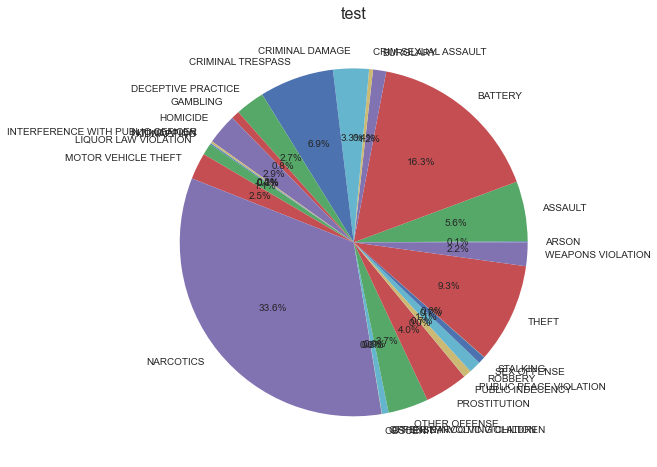

In [10]:
import matplotlib.pyplot as plt # plotting

plt.style.use(plt.style.available[9])
plt.figure(figsize=(8,8))
plt.pie(
    to_present.limit(100000).toPandas().groupby("PrimaryType").sum()["Arrest"],
    labels=to_present.limit(100000).toPandas().groupby("PrimaryType").sum().index,
    radius=1, 
    autopct='%0.1f%%', )
    #explode=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
plt.title('test', fontdict={'fontsize': 16})
plt.show()